In [36]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import matplotlib.pyplot as plt
%matplotlib inline

This code can work with either tf.VERSION = '1.4.1' (for MacOS High Sierra) or tf.VERSION = '0.12.1' (for RedHat based SuperComputer), functions may change for other versions. Also, this model does not have mini-batches.

Model Parameters:

In [50]:
training_set_split = 0.8
validation_set_split = 0.1
learning_rate = [0.001,0.01,0.1,1.0,1.5]
num_units = 5 #number of units in RNN cell
training_steps = 80 #number of epochs
display_step = 40 #number of epochs after which to display progress
optimize_using = "adagrad" #other option: "momentum"

In [38]:
print("Tensorflow version being used: " + str(tf.VERSION))

Tensorflow version being used: 1.4.1


Loading JSON file into dictionary called 'student_vectors'

In [39]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

Collecting unique CCSSM labels and Task IDs

In [40]:
ccssm_labels = []
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['ccssm'] not in ccssm_labels:
            ccssm_labels.append(j['ccssm'])
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique CCSSM Labels: " + str(len(ccssm_labels)))
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique CCSSM Labels: 4
Number of unique task IDs: 10
Number of students: 1255


Creating 1-hot encoding for Task IDs and CCSSM Labels

In [41]:
#pre-processing for using MultiLabelBinarizer
temp_ids = []
for i in task_ids:
    temp_ids.append([i])
temp_labels = []
for i in ccssm_labels:
    temp_labels.append([i])
    
#generating encodings
enc = MultiLabelBinarizer()
task_ids_1hot = (enc.fit_transform(temp_ids)).astype(float)
task_ids_classes = enc.classes_
task_ids_dict = dict(zip(task_ids, task_ids_1hot))
labels_1hot = enc.fit_transform(temp_labels).astype(float)
labels_classes = enc.classes_
labels_dict = dict(zip(ccssm_labels,labels_1hot))
print("1-hot encoding for CCSSM Labels:")
pp.pprint(labels_dict)
print("\n1-hot encoding for task IDs:")
pp.pprint(task_ids_dict)

1-hot encoding for CCSSM Labels:
{'CCSS.Math.3.NF.A.1': array([1., 0., 0., 0.]),
 'CCSS.Math.3.NF.A.3d': array([0., 1., 0., 0.]),
 'CCSS.Math.4.NF.B.3a': array([0., 0., 1., 0.]),
 'CCSS.Math.4.NF.B.3c': array([0., 0., 0., 1.])}

1-hot encoding for task IDs:
{'1zsCldT4p8.set1': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 '1zsCldT4p8.set2': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 '9wRCzK1G7F.partb': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'DebcfZEEmI.proper_fractions': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'Ok-iIHxjgx.parta': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'Ok-iIHxjgx.partb': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'hyei4uD81i.parta': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'kvig7fcCVc.partb': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'nl-M69Ez9k.parta': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'p7cfRPp-kQ.partb': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}


Generating input sequences of interactions to feed the network. Say we have 3 task IDs and 3 labels; here is an example of interaction vectors generated:
1. User correctly solves task 2 of label 3: [010   000   001 000]
2. User incorrectly solves task 1 of label 2: [000   100   000   010]

1-hot representation of task IDs: 
task ID 1: 1,0,0 ; 
task ID 2: 0,1,0 ; 
task ID 3: 0,0,1 ; 
and similarly for labels!

In the interaction vector, first 3 bits belong to taskID that user solved correctly; next 3 bits belong to taskID that user solved incorrectly; next 3 bits belong to label corresponding to task ID solved by user correctly and last 3 bits belong to label corresponding to the task ID solved by the user incorrectly.

In [42]:
sequences = []
output_y_ccssm = []
output_y_taskid = []
output_y = []
seqlen = []
incorrect_tid_vec = np.zeros((len(task_ids)), dtype=np.float)
incorrect_csm_vec = np.zeros((len(ccssm_labels)),dtype=np.float)
for i in student_vectors:
    temp_seq = []
    for j in student_vectors[i]:
        if(j['second_try'] == False): #ignoring second_try
            if(j['correct'] == True):
                vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec,labels_dict[j['ccssm']],incorrect_csm_vec])
                temp_seq.append(vec)
            else:
                vec = np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']],incorrect_csm_vec,labels_dict[j['ccssm']]])
                temp_seq.append(vec)
    seqlen.append(len(temp_seq))
    last_one = temp_seq.pop()
    output_y.append(last_one)
    output_y_ccssm.append(last_one[2*len(task_ids):])
    output_y_taskid.append(last_one[:2*len(task_ids)])
    sequences.append(temp_seq)
print("Sample interaction vector: ")
pp.pprint(sequences[0][0])
length_interaction_vector = 2*(len(task_ids)+len(ccssm_labels)) #length of interaction vector

Sample interaction vector: 
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


Finding maximum sequence length.

In [43]:
max_seqlen = max(seqlen)
print("Maximum sequence length: "+str(max_seqlen))

Maximum sequence length: 186


Padding the sequences according to maximum sequence length. Making padded sequences of shape: number of students, maximum sequence length, length of interaction vector.

In [44]:
padded_sequences = np.zeros(shape=(len(student_vectors),max_seqlen,length_interaction_vector),dtype=float)
for i in range(len(sequences)):
    for j in range(len(sequences[i])):
        padded_sequences[i][j] = sequences[i][j]
print("Sequences have been padded according to the maximum sequence length. Final shape: " + str(padded_sequences.shape))

Sequences have been padded according to the maximum sequence length. Final shape: (1255, 186, 28)


Split the data into training and testing sets. Will take random validation sets at the time of training.

In [45]:
split = round((training_set_split+validation_set_split)*len(student_vectors))

#separating training & validation set
training_x = padded_sequences[:split]
training_y = np.asarray(output_y)[:split]
training_y_ccssm = np.asarray(output_y_ccssm)[:split]
training_y_taskid = np.asarray(output_y_taskid)[:split]
training_seqlen = seqlen[:split]

#generating validation and training sets by implementing k-fold cross validation (k = maximum_position)
validation_set_size = math.floor(validation_set_split * len(student_vectors))
training_set_size = len(training_x) - validation_set_size
maximum_position = math.floor(len(training_x) / validation_set_size)
def get_next_train_valid_set(position):
    if(position>=maximum_position):
        position = position % maximum_position
    print("Picking validation set from position: "+str(position))
    valid_start = position*validation_set_size
    valid_end = valid_start + validation_set_size
    
    valid_set_x = training_x[valid_start : valid_end]
    valid_set_y = training_y[valid_start : valid_end]
    valid_set_y_ccssm = np.asarray(training_y_ccssm)[valid_start : valid_end]
    valid_set_y_taskid = np.asarray(training_y_taskid)[valid_start : valid_end]
    valid_set_seqlen = np.asarray(training_seqlen[valid_start:valid_end])
    
    train_set_x = np.concatenate((training_x[:valid_start], training_x[valid_end:]))
    train_set_y = np.concatenate((training_y[:valid_start], training_y[valid_end:]))
    train_set_y_ccssm = np.concatenate((np.asarray(training_y_ccssm)[:valid_start], np.asarray(training_y_ccssm)[valid_end:]))
    train_set_y_taskid = np.concatenate((np.asarray(training_y_taskid)[:valid_start], np.asarray(training_y_taskid)[valid_end:]))
    train_set_seqlen = np.concatenate((np.asarray(training_seqlen)[:valid_start],np.asarray(training_seqlen)[valid_end:]))
    
    if(len(train_set_x) != training_set_size): #just as a test
        print("that's not good it is:")
        print(train_set_x.shape)
    
    return (train_set_seqlen,valid_set_seqlen,valid_set_x,valid_set_y,valid_set_y_ccssm,valid_set_y_taskid,train_set_x,train_set_y,train_set_y_ccssm,train_set_y_taskid)

#separating test set
test_x = padded_sequences[split:]
test_y = np.asarray(output_y)[split:]
test_y_ccssm = np.asarray(output_y_ccssm)[split:]
test_y_taskid = np.asarray(output_y_taskid)[split:]
test_seqlen = seqlen[split:]

print("Splitting "+str(len(student_vectors))+" rows into "+str(training_set_size)+ " for training, "+str(validation_set_size)+" for validation and "+str(len(test_x)) + " for testing.")
print("Implemented "+str(maximum_position)+"-fold cross validation.")

Splitting 1255 rows into 1005 for training, 125 for validation and 125 for testing.
Implemented 9-fold cross validation.


Building the model

In [46]:
tf.reset_default_graph()

#defining placeholders
x = tf.placeholder(tf.float32, [None, max_seqlen, length_interaction_vector]) #(<batch_size>, <max_time>, <num_features>)
y = tf.placeholder(tf.float32, [None, length_interaction_vector]) #(<batch_size>, <num_features>)
y_taskid = tf.placeholder(tf.float32, [None, 2*len(task_ids)])
y_ccssm = tf.placeholder(tf.float32, [None, 2*len(ccssm_labels)])
seqlen_tf = tf.placeholder(tf.float32,[None])

#defining tensorflow variables
learning_tf_rate = tf.Variable(0.0, name="learning_tf_rate",dtype=tf.float32)

#dynamic RNN definition
def dynamicRNN(x):
    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
    
    #transformation on outputs needed, otherwise auc=0
    outputs = tf.transpose(outputs, [1, 0, 2])
    outputs = tf.gather(outputs, int(outputs.get_shape()[0]) - 1)
    out_size = length_interaction_vector
    logit = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn=None)
    if tf.VERSION == '0.12.1': #summit's tensorflow version API doc: https://www.tensorflow.org/versions/r0.12/api_docs/
        outputs = tf.sigmoid(logit)
    else:
        outputs = tf.nn.sigmoid(logit)
    return outputs

#making predictions
pred = dynamicRNN(x)
if tf.VERSION == '0.12.1': #summit's tensorflow version API doc: https://www.tensorflow.org/versions/r0.12/api_docs/
    pred_task,pred_ccssm = tf.split_v(value=pred,size_splits=[2*len(task_ids),2*len(ccssm_labels)],split_dim=1)
else:
    pred_task,pred_ccssm = tf.split(value=pred,num_or_size_splits=[2*len(task_ids),2*len(ccssm_labels)],axis=1)
    
# Define loss and optimizer
if tf.VERSION == '0.12.1': #summit's tensorflow version API doc: https://www.tensorflow.org/versions/r0.12/api_docs/
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, targets=y))
else:
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
if(optimize_using == "momentum"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_tf_rate,momentum=0.9).minimize(cost)
elif (optimize_using == "adagrad"):
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_tf_rate).minimize(cost)

# Evaluate model - use AUC to evaluate model
if tf.VERSION == '0.12.1': #summit's tensorflow version API doc: https://www.tensorflow.org/versions/r0.12/api_docs/
    auc,  opts = tf.contrib.metrics.streaming_auc(labels = test_y_taskid, predictions = pred_task, curve='ROC')
    auc_ccssm,  opts_ccssm = tf.contrib.metrics.streaming_auc(labels = test_y_ccssm, predictions = pred_ccssm, curve='ROC')
else:
    auc,  opts = tf.metrics.auc(labels = y_taskid, predictions = pred_task, curve='ROC')
    auc_ccssm,  opts_ccssm = tf.metrics.auc(labels = y_ccssm, predictions = pred_ccssm, curve='ROC')

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training the model for hyperparameter (learning rate) tuning.

In [51]:
plot_lr = []
plot_valid_auc_taskid = []
plot_valid_auc_ccssm = []
plot_train_auc_ccssm = []
plot_train_auc_taskid = []
with tf.Session() as sess:
    for l_r in learning_rate:
        plot_lr.append(l_r)    
        valid_taskid_list = []
        valid_ccssm_list = []
        for k_fold in range(1,maximum_position+1):
            # Initialize the variables (i.e. assign their default value)
            print(str(k_fold)+"-fold cross-validation")
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            assign_op = learning_tf_rate.assign(l_r)
            sess.run(assign_op)
            print("Current Learning Rate: "+str(learning_tf_rate.eval()))
            train_set_seqlen,valid_set_seqlen,valid_set_x,valid_set_y,valid_set_y_ccssm,valid_set_y_taskid,train_set_x,train_set_y,train_set_y_ccssm,train_set_y_taskid = get_next_train_valid_set(k_fold-1)
            for step in range(1, training_steps+1):
                batch_x = train_set_x
                batch_y = train_set_y
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, y_ccssm: train_set_y_ccssm, seqlen_tf: train_set_seqlen})

                if step % display_step == 0 or step == 1:
                    loss= sess.run([cost], feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, y_ccssm: train_set_y_ccssm, seqlen_tf: train_set_seqlen})
                    #print status
                    print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()))
            #calculate validation AUC
            valid_auc_ccssm, valid_opts_ccssm = sess.run([auc_ccssm,  opts_ccssm], feed_dict={x: valid_set_x, y: valid_set_y, y_taskid: valid_set_y_taskid, y_ccssm: valid_set_y_ccssm, seqlen_tf: valid_set_seqlen})
            valid_auc_taskid, valid_opts_taskid = sess.run([auc, opts], feed_dict={x: valid_set_x, y: valid_set_y, y_taskid: valid_set_y_taskid, y_ccssm: valid_set_y_ccssm, seqlen_tf: valid_set_seqlen})
            print("Valid_auc_taskid: " + str(valid_opts_taskid) + " Valid_auc_ccssm: " + str(valid_opts_ccssm) + " with k = "+str(k_fold))
            valid_taskid_list.append(valid_opts_taskid)
            valid_ccssm_list.append(valid_opts_ccssm)
            print("Optimization Finished!")
    
        #calculate training AUC (it should take both validation and training sets)
        train_auc_ccssm, train_opts_ccssm, train_auc_taskid, train_opts_taskid = sess.run([auc_ccssm,  opts_ccssm,auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, y_ccssm: training_y_ccssm, seqlen_tf: training_seqlen})

        print("Train_auc_taskid: " + str(train_opts_taskid))
        plot_train_auc_taskid.append(train_opts_taskid)
        print("Train_auc_ccssm: " + str(train_opts_ccssm))
        plot_train_auc_ccssm.append(train_opts_ccssm)
        
        #take average of validation AUCs
        valid_avg_ccssm = np.mean(valid_ccssm_list)
        valid_avg_taskid = np.mean(valid_taskid_list)
        
        print("Average Valid_auc_taskid: " + str(valid_avg_taskid))
        plot_valid_auc_taskid.append(valid_avg_taskid)
        print("Average Valid_auc_ccssm: " + str(valid_avg_ccssm))
        plot_valid_auc_ccssm.append(valid_avg_ccssm)

1-fold cross-validation
Current Learning Rate: 0.001
Picking validation set from position: 0
Step 1, Loss = [0.9383799], Learning Rate = 0.001
Step 40, Loss = [0.9382248], Learning Rate = 0.001
Step 80, Loss = [0.9381633], Learning Rate = 0.001
Valid_auc_taskid: 0.5 Valid_auc_ccssm: 0.5 with k = 1
Optimization Finished!
2-fold cross-validation
Current Learning Rate: 0.001
Picking validation set from position: 1
Step 1, Loss = [0.93838996], Learning Rate = 0.001
Step 40, Loss = [0.93823534], Learning Rate = 0.001
Step 80, Loss = [0.93817365], Learning Rate = 0.001
Valid_auc_taskid: 0.5 Valid_auc_ccssm: 0.5 with k = 2
Optimization Finished!
3-fold cross-validation
Current Learning Rate: 0.001
Picking validation set from position: 2
Step 1, Loss = [0.9383853], Learning Rate = 0.001
Step 40, Loss = [0.9382307], Learning Rate = 0.001
Step 80, Loss = [0.93816894], Learning Rate = 0.001
Valid_auc_taskid: 0.5 Valid_auc_ccssm: 0.5 with k = 3
Optimization Finished!
4-fold cross-validation
Curren

Step 1, Loss = [0.9381178], Learning Rate = 0.1
Step 40, Loss = [0.9281423], Learning Rate = 0.1
Step 80, Loss = [0.9181964], Learning Rate = 0.1
Valid_auc_taskid: 0.9789474 Valid_auc_ccssm: 0.9771429 with k = 7
Optimization Finished!
8-fold cross-validation
Current Learning Rate: 0.1
Picking validation set from position: 7
Step 1, Loss = [0.93811893], Learning Rate = 0.1
Step 40, Loss = [0.9281477], Learning Rate = 0.1
Step 80, Loss = [0.91821086], Learning Rate = 0.1
Valid_auc_taskid: 0.9982535 Valid_auc_ccssm: 0.9863223 with k = 8
Optimization Finished!
9-fold cross-validation
Current Learning Rate: 0.1
Picking validation set from position: 8
Step 1, Loss = [0.9381254], Learning Rate = 0.1
Step 40, Loss = [0.92814976], Learning Rate = 0.1
Step 80, Loss = [0.91820407], Learning Rate = 0.1
Valid_auc_taskid: 0.9789474 Valid_auc_ccssm: 0.9771429 with k = 9
Optimization Finished!
Train_auc_taskid: 0.9781258
Train_auc_ccssm: 0.9795083
Average Valid_auc_taskid: 0.98076504
Average Valid_auc

Plotting validation set ccssm auc across different learning rates.

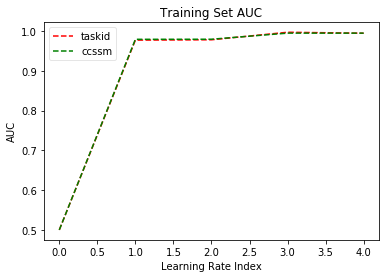

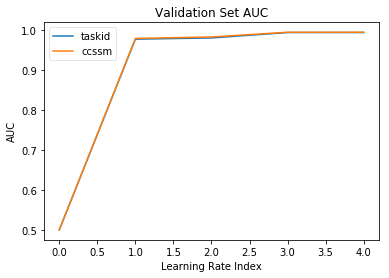

In [52]:
plt.title("Training Set AUC")
plt.xlabel("Learning Rate Index")
plt.ylabel("AUC")
plt.plot(plot_train_auc_taskid,'r--',label='taskid')
plt.plot(plot_train_auc_ccssm,'g--',label='ccssm')
plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.show()

plt.xlabel("Learning Rate Index")
plt.ylabel("AUC")
plt.title("Validation Set AUC")
plt.plot(plot_valid_auc_taskid,label='taskid')
plt.plot(plot_valid_auc_ccssm,label='ccssm')
plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.show()

#http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/

Now Training the model with hyperparameters chosen from above and calculating testing AUC.

In [54]:
final_l_r = plot_lr[np.argmax(plot_valid_auc_taskid)]
with tf.Session() as sess:
    for l_r in [final_l_r]:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        for step in range(1, training_steps+1):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, y_ccssm: training_y_ccssm, seqlen_tf: training_seqlen})
            
            if step % display_step == 0 or step == 1:
                loss= sess.run([cost], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, y_ccssm: training_y_ccssm, seqlen_tf: training_seqlen})
                #print status
                print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()))
        print("Optimization Finished!")
    
        #calculate training AUC
        train_auc_ccssm, train_opts_ccssm = sess.run([auc_ccssm,  opts_ccssm], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, y_ccssm: training_y_ccssm, seqlen_tf: training_seqlen})
        train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, y_ccssm: training_y_ccssm, seqlen_tf: training_seqlen})
        print("Train_auc_taskid: " + str(train_opts_taskid))
        print("Train_auc_ccssm: " + str(train_opts_ccssm))
        
    # Calculate test auc
    temp_auc_ccssm, temp_opts_ccssm = sess.run([auc_ccssm,  opts_ccssm], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid, y_ccssm: test_y_ccssm,seqlen_tf: test_seqlen})
    temp_auc_taskid, temp_opts_taskid = sess.run([auc, opts], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid, y_ccssm: test_y_ccssm,seqlen_tf: test_seqlen})
    print("Testing auc for taskid: " + str(temp_opts_taskid))
    print("Testing auc for ccssm: " + str(temp_opts_ccssm))

Final Learning Rate: 1.5
Step 1, Loss = [0.934497], Learning Rate = 1.5
Step 40, Loss = [0.8154692], Learning Rate = 1.5
Step 80, Loss = [0.75667655], Learning Rate = 1.5
Optimization Finished!
Train_auc_taskid: 0.9942653
Train_auc_ccssm: 0.9949387
Testing auc for taskid: 0.9859248
Testing auc for ccssm: 0.9883286
